<a href="https://colab.research.google.com/github/CoffeeTulip/CS39AA-Project/blob/main/ProjectPart3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# import all of the python modules/packages you'll need here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install datasets
!pip install nltk
!pip install sentencepiece
import datasets
from datasets import load_dataset
from datasets import DatasetDict
import nltk

nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

#Data Pre-processing

In [ ]:
# Convert dataset dict to dataset, seperate the splits from the whole so I can view it and alter it better
df = load_dataset("Amani27/massive_translation_dataset")
df = DatasetDict(df)

df_train = pd.DataFrame.from_dict(df['train'])
df_validation = pd.DataFrame.from_dict(df['validation'])
df_test = pd.DataFrame.from_dict(df['test'])
df = pd.concat([df_train, df_validation, df_test], ignore_index=True)

In [ ]:
columns_to_drop = ['id', 'split', 'de_DE', 'hi_IN', 'fr_FR', 'it_IT', 'ar_SA', 'nl_NL', 'ja_JP', 'pt_PT' ]
df = df.drop(columns = columns_to_drop)

#Text cleaning
*the text is pretty clean already... but just for practice :D*

In [ ]:
english_column = 'en_US'
spanish_column = 'es_ES'

# Tokenize English. The text dataset looked cleaned up already but just to be safe
english_text = ' '.join(df[english_column].astype(str).values)
english_tokens = word_tokenize(english_text.lower())

# Remove stopwords and punctuation
stop_words = set(stopwords.words('english') + list(string.punctuation))
english_filtered_tokens = [word for word in english_tokens if word.isalnum() and word not in stop_words]

# Get the most common words in English
english_common_words = Counter(english_filtered_tokens).most_common(10)

# Tokenize Spanish
spanish_text = ' '.join(df[spanish_column].astype(str).values)
spanish_tokens = word_tokenize(spanish_text.lower())  # Convert to lowercase for consistency

# Remove stopwords and punctuation
stop_words = set(stopwords.words('spanish') + list(string.punctuation))
spanish_filtered_tokens = [word for word in spanish_tokens if word.isalnum() and word not in stop_words]

# Get the most common words in Spanish
spanish_common_words = Counter(spanish_filtered_tokens).most_common(10)


# Display the results
print("Most common words in English:")
print(english_common_words)

print("\nMost common words in Spanish:")
print(spanish_common_words)

Most common words in English:
[('please', 1440), ('play', 1173), ('today', 849), ('list', 770), ('email', 718), ('new', 701), ('tell', 697), ('time', 650), ('set', 563), ('olly', 534)]

Most common words in Spanish:
[('favor', 1284), ('hoy', 865), ('lista', 859), ('correo', 859), ('mañana', 765), ('pon', 728), ('hora', 591), ('electrónico', 554), ('cuál', 542), ('puedes', 511)]


In [ ]:
from sklearn.model_selection import train_test_split

df.reset_index(drop=True, inplace=True)

X = df['en_US'].values
y = df['es_ES'].values

In [ ]:
# Drop the name Olly
df['en_US'] = df['en_US'].str.replace(r'\b(?:olly|Olly)\b', '', regex=True)
df['es_ES'] = df['es_ES'].str.replace(r'\b(?:olly|Olly)\b', '', regex=True)

In [ ]:
# Assuming df is your DataFrame with columns 'en_US' and 'es_ES'
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

#Quick Model
##T5-Small Hugging Face Translator model

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("translation", model="t5-small")

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Custom dataset class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=128, is_test=False):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        # Encode input text
        inputs = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        if self.is_test:
            # For test set, only input_ids and attention_mask are needed
            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
            }
        else:
            # Encode target text for training
            targets = self.tokenizer.encode_plus(
                target_text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': targets['input_ids'].squeeze()
            }

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

english_tokens = tokenizer(X_train, return_tensors='pt', padding=True, truncation=True)
valid_english_tokens = tokenizer(X_val, return_tensors='pt', padding=True, truncation=True)
test_english_tokens = tokenizer(X_test, return_tensors='pt', padding=True, truncation=True)

spanish_tokens = tokenizer(y_train, return_tensors='pt', padding=True, truncation=True)
valid_spanish_tokens = tokenizer(y_val, return_tensors='pt', padding=True, truncation=True)
test_spanish_tokens = tokenizer(y_test, return_tensors='pt', padding=True, truncation=True)

In [ ]:
test_dataset = CustomDataset(X_test, y_test, tokenizer, is_test=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model Testing

In [ ]:
learning_rates = [.1, .01, .001]
batch_sizes = [16, 32, 64]

num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CustomDataset(X_train, y_train, tokenizer)
valid_dataset = CustomDataset(X_val, y_val, tokenizer)

train_losses = []
val_losses = []

for lr in learning_rates:
    for batch_size in batch_sizes:

      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
      valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

      model = T5ForConditionalGeneration.from_pretrained('t5-small')
      optimizer = AdamW(model.parameters(), lr=lr)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
      #------------------------------------------------------------------------------
      model.to(device)
      model.train()

      epoch_train_losses = []
      epoch_val_losses = []

      for epoch in range(num_epochs):
          # Training phase
          for batch in dataloader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['labels'].to(device)

              outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
              loss = outputs.loss

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Validation phase
          model.eval()
          total_validation_loss = 0.0

          with torch.no_grad():
              for batch_val in valid_dataloader:
                  input_ids_val = batch_val['input_ids'].to(device)
                  attention_mask_val = batch_val['attention_mask'].to(device)
                  labels_val = batch_val['labels'].to(device)

                  outputs_val = model(input_ids_val, attention_mask=attention_mask_val, labels=labels_val)
                  loss_val = outputs_val.loss

                  total_validation_loss += loss_val.item()

          average_validation_loss = total_validation_loss / len(valid_dataloader)

          # Store losses for the current epoch
          epoch_train_losses.append(loss.item())
          epoch_val_losses.append(average_validation_loss)

          print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {average_validation_loss}')

          # Set the model back to training mode
          model.train()

      # Append the final losses for this combination
      train_losses.append(epoch_train_losses)
      val_losses.append(epoch_val_losses)

In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

# Print a table
table_data = []
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        table_data.append([f'LR={lr}, Batch={batch_size}', train_losses[i * len(batch_sizes) + j][-1], val_losses[i * len(batch_sizes) + j][-1]])

headers = ['Combination', 'Train Loss', 'Validation Loss']
table = tabulate(table_data, headers, tablefmt='grid', numalign="center", stralign="center")

print("Loss Values for Each Combination:")
print(table)

Loss Values for Each Combination:
+--------------------+--------------+-------------------+
|    Combination     |  Train Loss  |  Validation Loss  |
+====================+==============+===================+
|  LR=0.1, Batch=16  |   0.65961    |     0.715642      |
+--------------------+--------------+-------------------+
|  LR=0.1, Batch=32  |   0.727282   |     0.692585      |
+--------------------+--------------+-------------------+
|  LR=0.1, Batch=64  |   0.694337   |     0.690754      |
+--------------------+--------------+-------------------+
| LR=0.01, Batch=16  |   0.535801   |     0.507649      |
+--------------------+--------------+-------------------+
| LR=0.01, Batch=32  |   0.242965   |     0.219603      |
+--------------------+--------------+-------------------+
| LR=0.01, Batch=64  |   0.291425   |     0.232748      |
+--------------------+--------------+-------------------+
| LR=0.001, Batch=16 |   0.259864   |     0.172503      |
+--------------------+--------------+-

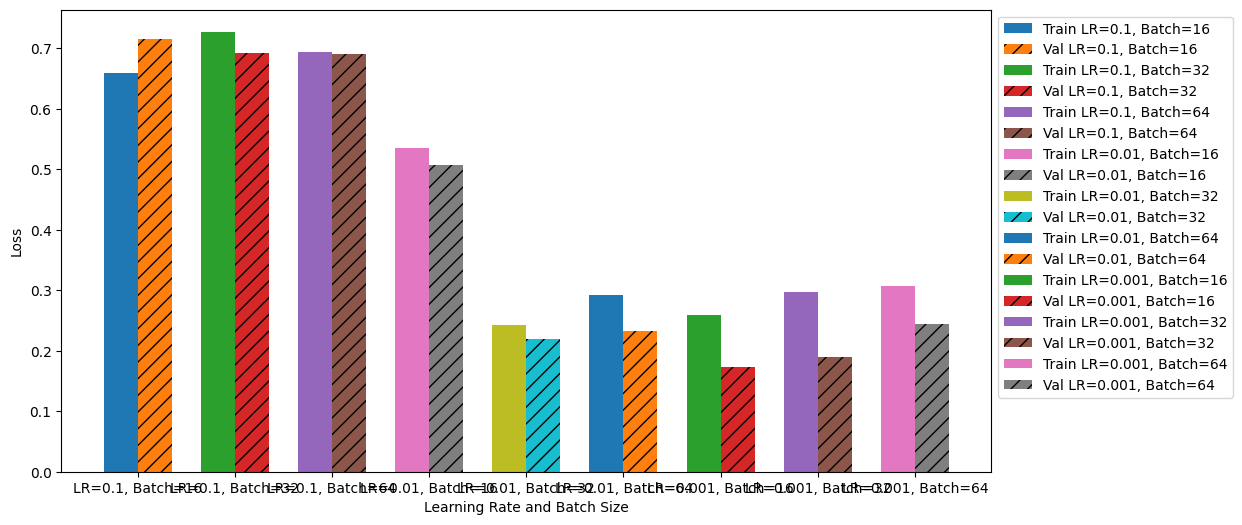

In [ ]:
# Bar graph
width = 0.35
x = np.arange(len(learning_rates) * len(batch_sizes))

fig, ax = plt.subplots(figsize=(12, 6))
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        train_bar = ax.bar(x[i * len(batch_sizes) + j] - width/2, train_losses[i * len(batch_sizes) + j][-1], width, label=f'Train LR={lr}, Batch={batch_size}')
        val_bar = ax.bar(x[i * len(batch_sizes) + j] + width/2, val_losses[i * len(batch_sizes) + j][-1], width, label=f'Val LR={lr}, Batch={batch_size}', hatch='//')

ax.set_xticks(x)
ax.set_xticklabels([f'LR={lr}, Batch={batch_size}' for lr in learning_rates for batch_size in batch_sizes])
ax.set_xlabel('Learning Rate and Batch Size')
ax.set_ylabel('Loss')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#Fine Tuning
#### Looking at the results from testing different hyperparameters above, the loss and batch size values that minimize loss are .001 and 16 respectivley.

In [ ]:
dataset = CustomDataset(X_train, y_train, tokenizer)
valid_dataset = CustomDataset(X_val, y_val, tokenizer)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

model = T5ForConditionalGeneration.from_pretrained('t5-small')
optimizer = AdamW(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
#------------------------------------------------------------------------------

In [ ]:
from torch.nn.utils import clip_grad_norm_

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

train_losses = []
val_losses = []

# Define clipping threshold, try .5
max_grad_norm = 1.0
early_stopping_patience = 3
early_stopping_counter = 0
best_validation_loss = float('inf')

num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()

        # Apply gradient clipping
        clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        optimizer.step()

    # Validation phase
    model.eval()
    total_validation_loss = 0.0

    with torch.no_grad():
        for batch_val in valid_dataloader:
            input_ids_val = batch_val['input_ids'].to(device)
            attention_mask_val = batch_val['attention_mask'].to(device)
            labels_val = batch_val['labels'].to(device)

            outputs_val = model(input_ids_val, attention_mask=attention_mask_val, labels=labels_val)
            loss_val = outputs_val.loss

            total_validation_loss += loss_val.item()

    average_validation_loss = total_validation_loss / len(valid_dataloader)

    # Store losses for the current epoch
    train_losses.append(loss.item())
    val_losses.append(average_validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {average_validation_loss}')

    # Early stopping check
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {epoch + 1} epochs without improvement.')
        break  # Stop training

    # Set the model back to training mode
    model.train()

Epoch 1/10, Training Loss: 0.18564429879188538, Validation Loss: 0.15351675579754206
Epoch 2/10, Training Loss: 0.15065938234329224, Validation Loss: 0.12648543099371287
Epoch 3/10, Training Loss: 0.1374073177576065, Validation Loss: 0.11402871488378598
Epoch 4/10, Training Loss: 0.10746469348669052, Validation Loss: 0.10722897431025138
Epoch 5/10, Training Loss: 0.1425897777080536, Validation Loss: 0.10211270703719212
Epoch 6/10, Training Loss: 0.08433931320905685, Validation Loss: 0.10169866724083057
Epoch 7/10, Training Loss: 0.07493957877159119, Validation Loss: 0.10001515432332571
Epoch 8/10, Training Loss: 0.11114301532506943, Validation Loss: 0.10067689146559972
Epoch 9/10, Training Loss: 0.05607796460390091, Validation Loss: 0.10106843380400768
Epoch 10/10, Training Loss: 0.059120748192071915, Validation Loss: 0.10309260467497203
Early stopping after 10 epochs without improvement.


# Save model, tokenizer, and model-related info

In [ ]:
saved_data = {'model': model.state_dict(),
              'tokenizer': tokenizer,
              'train_losses': train_losses,
              'val_losses': val_losses}

# Save the dictionary to a file using torch.save
torch.save(saved_data, '/content/gdrive/My Drive/Colab Notebooks/CS39AA/SpanishEnglishTranslator')

#Load from saved model
*optional*

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the saved dictionary
loaded_data = torch.load('/content/gdrive/My Drive/Colab Notebooks/CS39AA/SpanishEnglishTranslator')

# Extract model, tokenizer, and model-related info
loaded_model = T5ForConditionalGeneration.from_state_dict(loaded_data['model'])
loaded_tokenizer = loaded_data['tokenizer']
loaded_train_losses = loaded_data['train_losses']
loaded_val_losses = loaded_data['val_losses']

In [66]:
# Create a list of dictionaries for each epoch
data = [{"Epoch": i + 1, "Training Loss": train_loss, "Validation Loss": val_loss}
        for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses))]

# Display the table using tabulate
table = tabulate(data, headers = 'keys', tablefmt='grid', numalign="center", stralign="center")

# Print the table
print(table)

# Optionally, save the table to a file
with open("loss_table.txt", "w") as f:
    f.write(table)

+---------+-----------------+-------------------+
|  Epoch  |  Training Loss  |  Validation Loss  |
+=========+=================+===================+
|    1    |    0.185644     |     0.153517      |
+---------+-----------------+-------------------+
|    2    |    0.150659     |     0.126485      |
+---------+-----------------+-------------------+
|    3    |    0.137407     |     0.114029      |
+---------+-----------------+-------------------+
|    4    |    0.107465     |     0.107229      |
+---------+-----------------+-------------------+
|    5    |     0.14259     |     0.102113      |
+---------+-----------------+-------------------+
|    6    |    0.0843393    |     0.101699      |
+---------+-----------------+-------------------+
|    7    |    0.0749396    |     0.100015      |
+---------+-----------------+-------------------+
|    8    |    0.111143     |     0.100677      |
+---------+-----------------+-------------------+
|    9    |    0.056078     |     0.101068      |


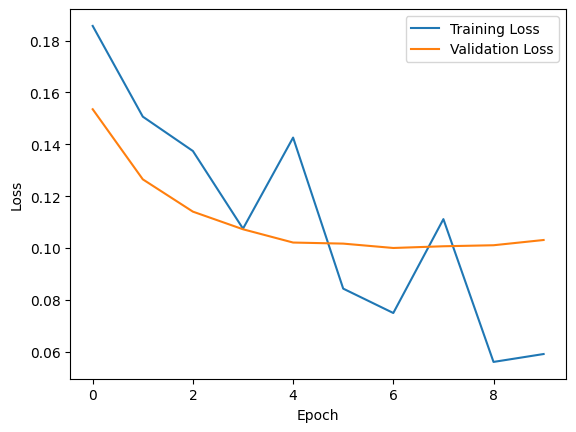

In [ ]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
input_text = "how are you?"
input_tokens = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    model.eval()
    input_ids = input_tokens['input_ids'].to(device)
    attention_mask = input_tokens['attention_mask'].to(device)

    model = model.to(device)

    # Generate translations
    translation_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=50, num_beams=4)

# Decode the generated translation
translation_text = tokenizer.decode(translation_ids[0], skip_special_tokens=True)
print("Input Text:", input_text)
print("Translated Text:", translation_text)

Input Text: how are you?
Translated Text: como estas


In [ ]:
# List of input texts
input_texts = ["Whats up", "Whats your name", "Hows it going", "Whats going on", "How are you doing"]

# List to store translations
translations = []

# Loop through each input text
for input_text in input_texts:
    input_tokens = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():
        model.eval()
        input_ids = input_tokens['input_ids'].to(device)
        attention_mask = input_tokens['attention_mask'].to(device)

        # Generate translations
        translation_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=50, num_beams=4)

    # Decode the generated translation
    translation_text = tokenizer.decode(translation_ids[0], skip_special_tokens=True)

    # Store the translation
    translations.append(translation_text)

# Print the results
for input_text, translation_text in zip(input_texts, translations):
    print("Input Text:", input_text)
    print("Translated Text:", translation_text)
    print('-' * 50)


Input Text: Whats up
Translated Text: que pasa
--------------------------------------------------
Input Text: Whats your name
Translated Text: como te llamas
--------------------------------------------------
Input Text: Hows it going
Translated Text: cómo va
--------------------------------------------------
Input Text: Whats going on
Translated Text: que esta pasando
--------------------------------------------------
Input Text: How are you doing
Translated Text: como estas
--------------------------------------------------


In [ ]:
!pip install tqdm nltk sacrebleu
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch

#BLEU Score
BLEU stands for billingual evaluation understudy, and is a score between 0 and 1. BLEU score is a metric based on the idea that the closer a generated text is to the human generated target, text the better. Its important to note though, that with language and scentences the quantiative data that is being assesed against the model is human generated, so a scentence can have multiple completley correct translations.

With that, the BLEU score will be a score between 0 and 1, with near 0 or 1 scores being not ideal.

In [54]:
# Switch model to evaluation mode
model.eval()

# Smoothing function for generated translations with 0 ngrams
smooth = SmoothingFunction().method1

# Lists to store references and translations
references = []
translations = []

# Iterate over test batches
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Translating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Generate translations
        translation_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=50, num_beams=4)

        # Decode the generated translation
        generated_text = tokenizer.decode(translation_ids[0], skip_special_tokens=True)

        # Fetch corresponding target sequences from the dataset
        if 'labels' in batch:
            # Training set
            target_sequence = tokenizer.decode(batch['labels'][0], skip_special_tokens=True)
        else:
            # Test set
            target_sequence = tokenizer.decode(input_ids[0], skip_special_tokens=True)

        # Collect references and translations for evaluation
        references.append([target_sequence])
        translations.append(generated_text)

# Convert references into the format expected by corpus_bleu
references = [[reference[0].split()] for reference in references]

# Tokenize generated translations for BLEU score calculation
generated_tokens = [translation.split() for translation in translations]

# Calculate BLEU score with smoothing method
bleu_score = corpus_bleu(references, generated_tokens, smoothing_function=smooth)
print("BLEU Score:", bleu_score)

Translating: 100%|██████████| 52/52 [01:09<00:00,  1.33s/it]

BLEU Score: 0.0031966938987175895
